In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import sys
sys.path.append("..")
from common_functions import image_data_generation


In [2]:
dataset_path = '../images/ROI_pollub/'
params = {'dim': (100,100),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': 3
        }
X,y_categorical,y = image_data_generation(dataset_path,params)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Nombre de plis pour la validation croisée k-fold
k = 5

# Créer une instance de StratifiedKFold avec k plis
skf = StratifiedKFold(n_splits=k)

In [4]:
learning_rate=2e-5
learning_rate2=5e-6

In [5]:
# Liste pour stocker les scores de validation
scores = {i:{'history':None,'history_fine_tuning':None,'score_test':None} for i in range(k)}

def eval_cnn(i,train_index,val_test_index):
    # Spécifie les données d'entrainement
    X_train = X[train_index]
    y_train = y[train_index]

    # Spécifie les données de validation et de test
    skf2 = StratifiedKFold(n_splits=2)
    test_index,val_index = next(skf2.split(X[val_test_index], y[val_test_index]))
    X_val = X[val_test_index][val_index]
    y_val = y[val_test_index][val_index]
    X_test = X[val_test_index][test_index]
    y_test = y[val_test_index][test_index]

    y_train = keras.utils.to_categorical(y_train, num_classes=params['n_classes'])
    y_val = keras.utils.to_categorical(y_val, num_classes=params['n_classes'])
    y_test = keras.utils.to_categorical(y_test, num_classes=params['n_classes'])

    # Create the VGG16 model for feature extraction
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(params['dim'][0], params['dim'][1],params['n_channels']))

    # Freeze the layers of the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Create the top layers for feature extraction
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(params['n_classes'], activation='softmax'))

    # Compile the model for feature extraction
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraîner le classifieur sur les données d'entraînement
    print(f'Fold {i}')
    scores[i]['history'] = model.fit(x=X_train,y=y_train,validation_data=(X_val,y_val),epochs=50)

    # Unfreeze the upper layers of the convolutional base
    for layer in model.layers[0].layers[15:]:
        layer.trainable = True
    
    # Compile the model for fine-tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate2), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraîner le classifieur sur les données d'entraînement
    print(f'Fold {i} fine tuning')
    scores[i]['history_fine_tuning'] = model.fit(x=X_train,y=y_train,validation_data=(X_val,y_val),epochs=100)

    scores[i]['score_test'] = model.evaluate(X_test, y_test)
    return

In [6]:
# Train the model for feature extraction
# Effectuer la validation croisée
for i, (train_index, val_test_index) in enumerate(skf.split(X, y)):
    if i in [0,1,4]:
        continue
    eval_cnn(i,train_index,val_test_index)

Fold 2
Epoch 1/50
126/126 [==============================] - 16s 94ms/step - loss: 0.9710 - accuracy: 0.6539 - val_loss: 0.8070 - val_accuracy: 0.8204
Epoch 2/50
126/126 [==============================] - 9s 70ms/step - loss: 0.7409 - accuracy: 0.7562 - val_loss: 0.6411 - val_accuracy: 0.9202
Epoch 3/50
126/126 [==============================] - 9s 71ms/step - loss: 0.6260 - accuracy: 0.7612 - val_loss: 0.5466 - val_accuracy: 0.9461
Epoch 4/50
126/126 [==============================] - 9s 71ms/step - loss: 0.5584 - accuracy: 0.7742 - val_loss: 0.4861 - val_accuracy: 0.8822
Epoch 5/50
126/126 [==============================] - 9s 75ms/step - loss: 0.5154 - accuracy: 0.7804 - val_loss: 0.4496 - val_accuracy: 0.8363
Epoch 6/50
126/126 [==============================] - 9s 73ms/step - loss: 0.4882 - accuracy: 0.7782 - val_loss: 0.4194 - val_accuracy: 0.8363
Epoch 7/50
126/126 [==============================] - 9s 72ms/step - loss: 0.4677 - accuracy: 0.7849 - val_loss: 0.3975 - val_accuracy

In [7]:
scores

{0: {'history': None, 'history_fine_tuning': None, 'score_test': None},
 1: {'history': None, 'history_fine_tuning': None, 'score_test': None},
 2: {'history': <keras.callbacks.History at 0x21aa054ef50>,
  'history_fine_tuning': <keras.callbacks.History at 0x21bdfa4a3e0>,
  'score_test': [0.2820223569869995, 0.8982036113739014]},
 3: {'history': <keras.callbacks.History at 0x21bde5bdd50>,
  'history_fine_tuning': <keras.callbacks.History at 0x21aaa267250>,
  'score_test': [0.6650022268295288, 0.7884231805801392]},
 4: {'history': None, 'history_fine_tuning': None, 'score_test': None}}

In [8]:
import os
path = 'Results/'
optimizer='Adam'
output_path = path + f"{optimizer}_k={k}_{learning_rate}_{learning_rate2}"
if not os.path.exists(output_path):
    os.makedirs(output_path)
for i in [2,3]:
    for metric in ['accuracy','val_accuracy','loss','val_loss']:
        np.save(f"{output_path}/history_{i}_{learning_rate}_{learning_rate2}_{metric}.npy",np.concatenate((scores[i]['history'].history[metric],scores[i]['history_fine_tuning'].history[metric])))
    for j,metric in enumerate(['test_loss','test_accuracy']):
        np.save(f"{output_path}/value_{i}_{learning_rate}_{learning_rate2}_{metric}.npy",scores[i]['score_test'][j])

In [9]:
f"{output_path}/history_{i}_{learning_rate}_{learning_rate2}_{metric}.npy"

'../Results/RMSProp_k=4_2e-05_5e-06/history_1_2e-05_5e-06_test_accuracy.npy'

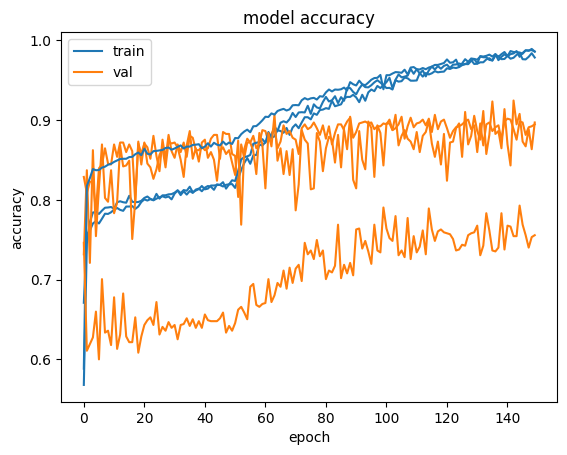

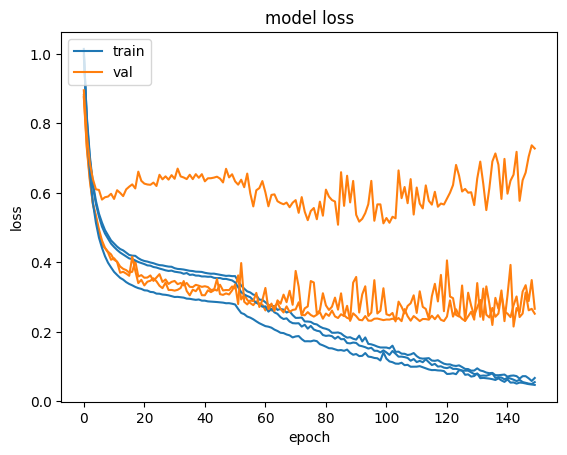

Moyenne accuracy : 0.9834331075350443
Moyenne val_accuracy : 0.8491017818450928
Moyenne loss : 0.05672928815086683
Moyenne val_loss : 0.415439893802007


In [9]:
last_values = {i:[] for i in ['accuracy','val_accuracy','test_accuracy','loss','val_loss','test_loss']}
for metric in ['accuracy','loss']:
    for i in range(k):
        values = np.load(f"history_{i}_{learning_rate}_{learning_rate2}_{metric}.npy")
        val_values = np.load(f"history_{i}_{learning_rate}_{learning_rate2}_val_{metric}.npy")
        last_values[f"{metric}"].append(values[-1])
        last_values[f"val_{metric}"].append(val_values[-1])
        last_values[f"test_{metric}"].append(np.load(f"value_{i}_{learning_rate}_{learning_rate2}_test_{metric}.npy"))

        plt.plot(values,'tab:blue')
        plt.plot(val_values,'tab:orange')

    plt.title(f"model {metric}")
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

for metric in ['accuracy','val_accuracy','loss','val_loss']:
    print(f"Moyenne {metric} : {np.mean(last_values[metric])}")